In [1]:
packages <- c("ggplot2", "dplyr", "patchwork", "tidyr")
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}
source("../../../utils/r_themes.r")

## Montage loading and rasterizing

In [2]:
montage_image_path <- file.path("../../../figures/terminal_montage_figure/figures/terminal_montage.png")


In [3]:
# load the images and rasterize them
montage_image <- png::readPNG(montage_image_path)
montage_grob <- ggplotify::as.ggplot(grid::rasterGrob(montage_image, width = unit(1, "npc"), height = unit(1, "npc"))) +
    theme_void() + 
    theme(plot.margin = margin(0, 0, 0, 0))

## Whole image intensity plot

In [4]:
intensity_features_file_path <- file.path(
    "../../../1.ground_truth/data/0.ground_truth/annexinv_intensity_features_df.parquet"
)
# Read the intensity features
intensity_features_df <- arrow::read_parquet(intensity_features_file_path)
# tidy long
intensity_features_df <- intensity_features_df %>%
    pivot_longer(
        cols = colnames(intensity_features_df)[-1],
        names_to = "feature",
        values_to = "value"
    )

# select only annexin features 
intensity_features_df$channel <- gsub("Intensity_", "", intensity_features_df$feature)
intensity_features_df$channel <- sub(".*_(.*)", "\\1", intensity_features_df$feature)
intensity_features_df <- intensity_features_df %>% filter(
    channel == "AnnexinV"
)

# get only Intensity_MeanIntensity_AnnexinV feature
intensity_features_df <- intensity_features_df %>% filter(
    feature == "Intensity_MeanIntensity_AnnexinV"
)

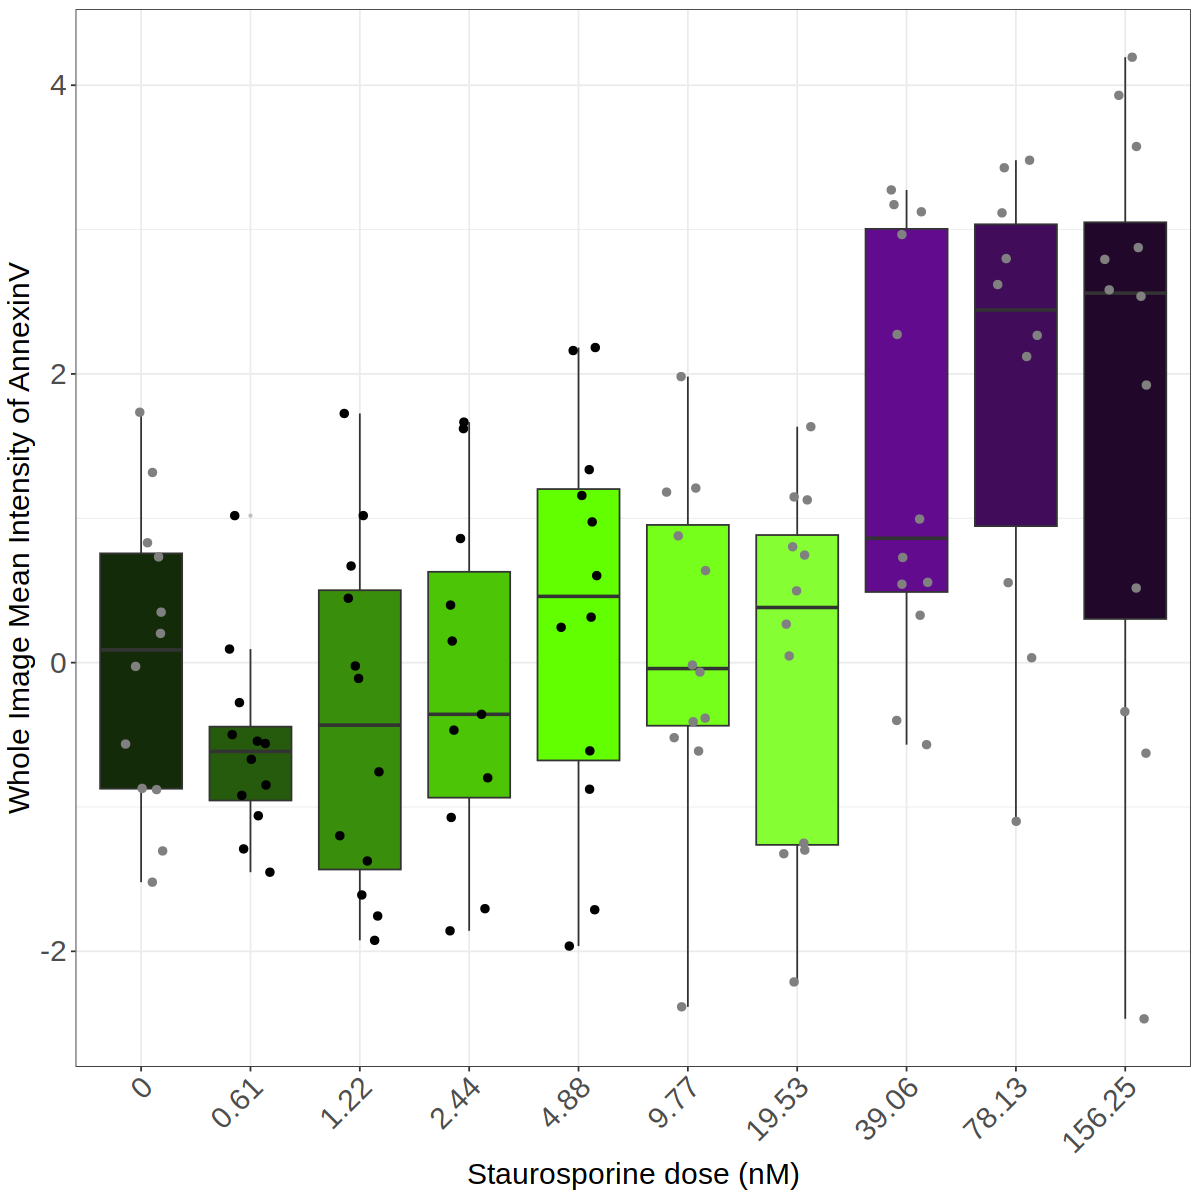

In [5]:

intensity_features_df$Metadata_dose <- as.character(intensity_features_df$Metadata_dose)
intensity_features_df$Metadata_dose <- factor(
    intensity_features_df$Metadata_dose,
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
)
    )
points_color_palette_for_dose <- c(
    "0" = "#808080",
    "0.61" = "#000000",
    "1.22" = "#000000",
    "2.44" = "#000000",
    "4.88" = "#000000",
    "9.77" = "#808080",
    "19.53" = "#808080",
    "39.06" = "#808080",
    "78.13" = "#808080",
    "156.25" = "#808080"
)
# plot the intensity_features_df
width <- 10
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
intensity_plot <- (
    ggplot(intensity_features_df, aes(x = Metadata_dose, y = value, fill = Metadata_dose))
    + geom_boxplot(aes(group=Metadata_dose), outlier.size = 0.5, outlier.colour = "gray")
    # add jittered points
    + geom_jitter(width = 0.2, size = 2, alpha = 1, aes(color = Metadata_dose))
    + labs(
        x = "Staurosporine dose (nM)",
        y = "Whole Image Mean Intensity of AnnexinV"
    )
    + theme_bw()
        + theme(
        axis.text.x = element_text(size = 18, angle = 45, hjust = 1),
        axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        plot.title = element_text(size = 18, hjust = 0.5),
        legend.position = "none",
        strip.text = element_text(size = 18),
            
        legend.title = element_text(size=20)
    )
    + scale_fill_manual(values = color_palette_dose)
    # add color to jitter points
    + scale_color_manual(values = points_color_palette_for_dose)
)
intensity_plot

## sc UMAP plot

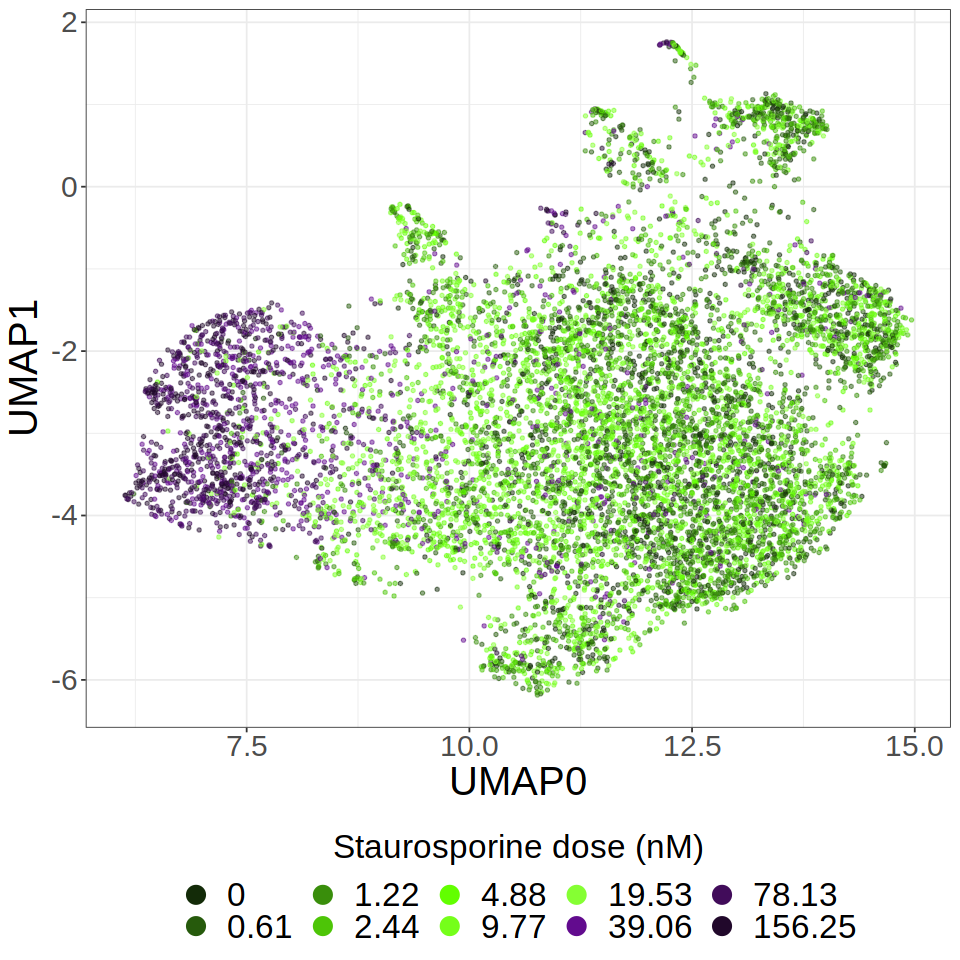

In [6]:
data_mode <- "terminal"
# set paths 
umap_file_path <- file.path("../../../data/umap/","terminal_umap_transformed.parquet")
umap_file_path <- normalizePath(umap_file_path)
umap_df <- arrow::read_parquet(umap_file_path)
# add nM to the dose column
# umap_df$Metadata_dose <- paste0(umap_df$Metadata_dose, " nM")
# make the dose a factor with levels
umap_df$Metadata_dose <- factor(umap_df$Metadata_dose, levels = c(
    "0",
    "0.61",
    "1.22",
    "2.44",
    "4.88",
    "9.77",
    "19.53",
    "39.06",
    "78.13",
    "156.25"
    )
    )


# make a ggplot of the umap
width <- 8
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
umap_plot <- (
    ggplot(data = umap_df, aes(x = UMAP0, y = UMAP1, color = Metadata_dose))
    + geom_point(size = 0.9, alpha = 0.5)
    + theme_bw()
    
    + labs( x = "UMAP0", y = "UMAP1")
    + theme(
        strip.text.x = element_text(size = 18),
        strip.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.title.x = element_text(size = 24),
        axis.title.y = element_text(size = 24),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        legend.position = "bottom",
        legend.box = "horizontal",
    
        
        )
    + scale_color_manual(values = color_palette_dose)
    + guides(
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Staurosporine dose (nM)",
            title.position = "top",
            title.hjust = 0.5,
            # make them horizontal
            nrow = 2,
        )
    )

    
)
umap_plot

## Final plot

pdf 
  2

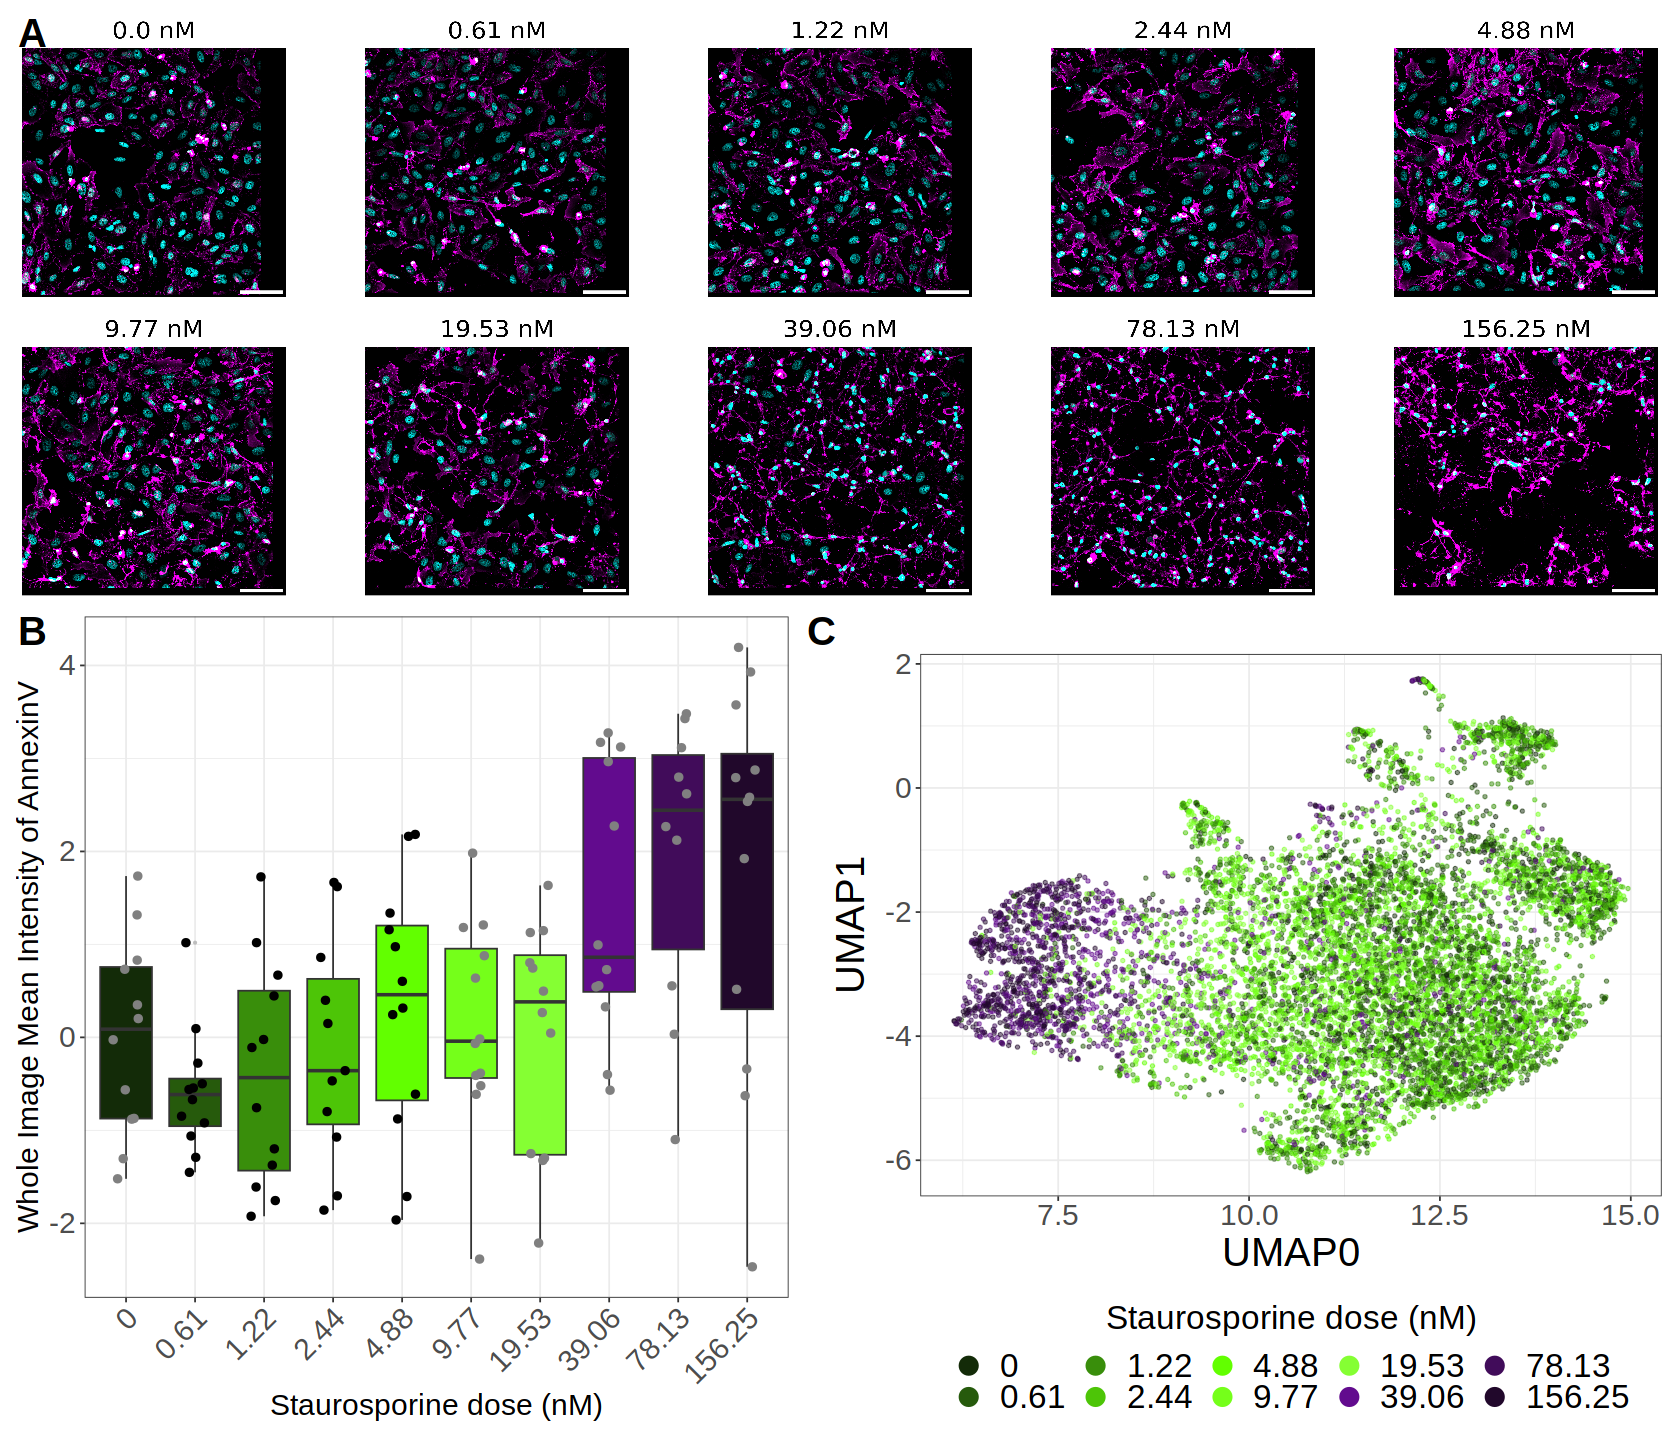

In [7]:
width <- 14
height <- 12
dpi <- 600
options(repr.plot.width = width, repr.plot.height = height)
layout <- "
    AAAA
    BBCC
    "
final_plot <- (
    wrap_elements(full = montage_grob, clip = TRUE)
    +  wrap_elements(full = intensity_plot)
    + umap_plot
    + plot_layout(
        design = layout, 
        heights = c(1, 1),  # montage gets 2x height of bottom row

    )
    + plot_annotation(tag_levels = 'A')
    & theme(
        plot.tag = element_text(size = 24, face = "bold",hjust = 0.5, vjust = 1),
    )
)
png(filename = "../figures/terminal_montage_figure.png", width = width, height = height, units = "in", res = dpi)
final_plot
dev.off()
final_plot